In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import openpathsampling.storage as st

storage = st.AnalysisStorage("mstis.nc")

In [2]:
len(storage.steps)

400

In [3]:
mstis = storage.networks.load(0)
retis = mstis.sampling_transitions[0]

### Defining labels

Everything is actually done in terms of ensembles. We can map the ensembles to any labels. In our case, we use the initial replica ID associated with the ensemble. We use this as both the numeric and string label.

In [4]:
sset0 = storage.samplesets[0]
numeric_labels = { s.ensemble : s.replica for s in sset0}
string_labels = { s.ensemble : str(s.replica) for s in sset0 }
numeric_to_string = { numeric_labels[e] : string_labels[e] for e in numeric_labels.keys()}

## Trace of ensemble visited by a replica

In the plot below, you'll see we set the labels on the axis as sset0[e].replica, so we use the replica ID associated with the ensemble in the first timestep.

In [5]:
%%time
trace_1 = paths.trace_ensembles_for_replica(0, storage)

CPU times: user 8.54 ms, sys: 2.88 ms, total: 11.4 ms
Wall time: 9.45 ms


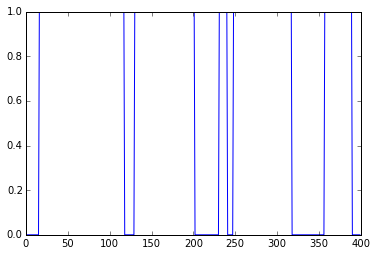

In [6]:
plt.plot([numeric_labels[e] for e in trace_1])

### Replica flow

In [7]:
repx_net = paths.ReplicaNetwork(storage=storage)
print repx_net

In [8]:
flow = repx_net.flow(bottom=retis.minus_ensemble, top=retis.ensembles[-1])
print flow

{<openpathsampling.ensemble.TISEnsemble object at 0x10fea6210>: 0.0, <openpathsampling.ensemble.MinusInterfaceEnsemble object at 0x10fead050>: 0.0, <openpathsampling.ensemble.TISEnsemble object at 0x10fceca50>: 0.0, <openpathsampling.ensemble.TISEnsemble object at 0x10fced090>: 0.0, <openpathsampling.ensemble.TISEnsemble object at 0x10fead290>: 0.4590909090909091, <openpathsampling.ensemble.MinusInterfaceEnsemble object at 0x110207510>: 0.0, <openpathsampling.ensemble.TISEnsemble object at 0x10fced550>: 0.0, <openpathsampling.ensemble.UnionEnsemble object at 0x10fce8690>: 0.0, <openpathsampling.ensemble.TISEnsemble object at 0x10fead190>: 0.0, <openpathsampling.ensemble.MinusInterfaceEnsemble object at 0x10fba0e90>: 1.0, <openpathsampling.ensemble.TISEnsemble object at 0x10fcedfd0>: 0.0, <openpathsampling.ensemble.TISEnsemble object at 0x10faf4450>: 0.0, <openpathsampling.ensemble.TISEnsemble object at 0x10fb83450>: 0.0}


In [9]:
flow_num = {numeric_labels[k] : flow[k] for k in flow.keys()}
print flow_num

{0: 0.0, 1: 0.0, 2: 0.4590909090909091, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, -1: 1.0, -3: 0.0, -2: 0.0}


In [10]:
sorted_vals = []
for k in sorted(flow_num.keys()):
    sorted_vals.append(flow_num[k])

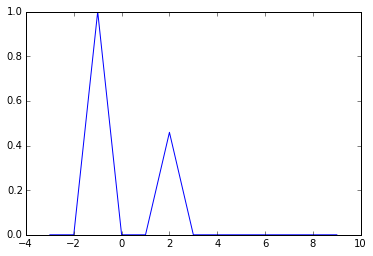

In [11]:
plt.plot(sorted(flow_num.keys()), sorted_vals)

### Trips

Now we calculate "up" trips, "down" trips, and round-trips.

In [12]:
repx_net.trips(bottom=retis.minus_ensemble, top=retis.ensembles[-1])

{'down': [187], 'round': [], 'up': []}

### Transition matrix

The transition matrix is the (unsymmetrized) matrix of the transition probabilities. By default, it automatically sets its order from the Cuthill-McKee reverse ordering algorithm.

In [13]:
repx_net.transition_matrix()

-3         0         1         3         9         7         6  \
-3  0.000000  0.019608  0.000000  0.000000  0.000000  0.000000  0.000000   
0   0.019608  0.000000  0.098039  0.000000  0.000000  0.000000  0.000000   
1   0.000000  0.098039  0.000000  0.019608  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.019608  0.000000  0.039216  0.000000  0.000000   
9   0.000000  0.000000  0.000000  0.039216  0.000000  0.039216  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.039216  0.000000  0.049020   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.049020  0.000000   
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.078431   
-1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
-2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           2        -1        -2         5         4         8  
-3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
7   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
6   0.078431  0.000000  0.000000  0.000000  0.000000  0.000000  
2   0.000000  0.009804  0.000000  0.000000  0.000000  0.000000  
-1  0.009804  0.000000  0.000000  0.000000  0.000000  0.000000  
-2  0.000000  0.000000  0.000000  0.029412  0.000000  0.000000  
5   0.000000  0.000000  0.029412  0.000000  0.078431  0.000000  
4   0.000000  0.000000  0.000000  0.078431  0.000000  0.019608  
8   0.000000  0.000000  0.000000  0.000000  0.019608  0.000000

If you would like to set a different order, that can be done by providing a list of the ensembles in whatever order you choose:

In [14]:
import numpy as np
perm = np.random.permutation(len(mstis.all_ensembles))
print perm

[10  4  3  9  6 11 12  8  2  0  5  1  7]


In [15]:
order = [mstis.all_ensembles[p] for p in perm]
repx_net.transition_matrix(index_order=order)

-1         4         5         9         0        -2        -3  \
-1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.078431  0.000000  0.000000  0.000000  0.000000   
5   0.000000  0.078431  0.000000  0.000000  0.000000  0.029412  0.000000   
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.019608   
-2  0.000000  0.000000  0.029412  0.000000  0.000000  0.000000  0.000000   
-3  0.000000  0.000000  0.000000  0.000000  0.019608  0.000000  0.000000   
3   0.000000  0.000000  0.000000  0.039216  0.000000  0.000000  0.000000   
7   0.000000  0.000000  0.000000  0.039216  0.000000  0.000000  0.000000   
2   0.009804  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.000000  0.019608  0.000000  0.000000  0.000000  0.000000  0.000000   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.000000  0.000000  0.000000  0.000000  0.098039  0.000000  0.000000   

           3         7         2         8         6         1  
-1  0.000000  0.000000  0.009804  0.000000  0.000000  0.000000  
4   0.000000  0.000000  0.000000  0.019608  0.000000  0.000000  
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
9   0.039216  0.039216  0.000000  0.000000  0.000000  0.000000  
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.098039  
-2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
-3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.019608  
7   0.000000  0.000000  0.000000  0.000000  0.049020  0.000000  
2   0.000000  0.000000  0.000000  0.000000  0.078431  0.000000  
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
6   0.000000  0.049020  0.078431  0.000000  0.000000  0.000000  
1   0.019608  0.000000  0.000000  0.000000  0.000000  0.000000

### Mixing matrix

Same as the transition matrix $T$, but $\frac{1}{2}(T+T^T)$.

In [16]:
repx_net.mixing_matrix()

-3         0         1         3         9         7         6  \
-3  0.000000  0.019608  0.000000  0.000000  0.000000  0.000000  0.000000   
0   0.019608  0.000000  0.098039  0.000000  0.000000  0.000000  0.000000   
1   0.000000  0.098039  0.000000  0.019608  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.019608  0.000000  0.039216  0.000000  0.000000   
9   0.000000  0.000000  0.000000  0.039216  0.000000  0.039216  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.039216  0.000000  0.049020   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.049020  0.000000   
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.078431   
-1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
-2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           2        -1        -2         5         4         8  
-3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
7   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
6   0.078431  0.000000  0.000000  0.000000  0.000000  0.000000  
2   0.000000  0.009804  0.000000  0.000000  0.000000  0.000000  
-1  0.009804  0.000000  0.000000  0.000000  0.000000  0.000000  
-2  0.000000  0.000000  0.000000  0.029412  0.000000  0.000000  
5   0.000000  0.000000  0.029412  0.000000  0.078431  0.000000  
4   0.000000  0.000000  0.000000  0.078431  0.000000  0.019608  
8   0.000000  0.000000  0.000000  0.000000  0.019608  0.000000

### Making a pretty picture

In [17]:
repxG = paths.ReplicaNetworkGraph(repx_net)

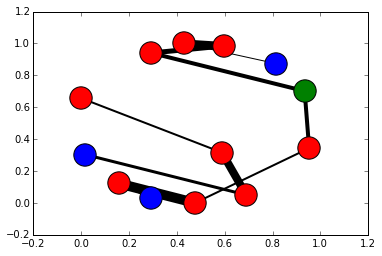

In [18]:
# draw('graphviz') gives better results, but requires pygraphviz
repxG.draw('spring')

Blue is a minus interface, red is a normal interface. Multiple state outer interfaces (not in this example) would be green.

### Alternate way of calculating transitions

There's another, perhaps better, way to calculate transitions. This does double count, but doesn't care if the how the transition happened (only that it did).

In [19]:
transitions = repx_net.transitions_from_traces(storage)

In [20]:
for (k1, k2)  in transitions.keys():
    print numeric_labels[k1], numeric_labels[k2], transitions[(k1, k2)]

8 4 2
6 2 8
2 -1 1
9 7 4
1 0 10
4 8 2
0 1 10
4 5 8
6 7 5
-1 2 1
9 3 4
7 9 4
5 4 8
2 6 8
3 9 4
5 -2 3
-2 5 3
7 6 5
-3 0 2
1 3 2
3 1 2
0 -3 2


In [21]:
for (k1, k2) in repx_net.analysis['n_accepted'].keys():
        print numeric_labels[k1], numeric_labels[k2], repx_net.analysis['n_accepted'][(k1, k2)]

8 4 2
2 6 8
2 -1 1
9 7 4
1 0 10
4 8 2
0 1 10
4 5 8
6 7 5
-1 2 1
9 3 4
7 9 4
5 4 8
6 2 8
3 9 4
-2 5 3
5 -2 3
7 6 5
-3 0 2
1 3 2
3 1 2
0 -3 2
